# Predicting the Status of Wells Across Tanzania

Exploration done by WellWatchers Avi Saraf, Lily Zhang, and Cindy Zhao.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

###Data preparation

In [4]:
df_values = pd.read_csv("clean_training_set_values.csv")
df_labels = pd.read_csv("training_set_labels.csv")

In [5]:
#merge the features (i.e. values) and the labels into one DataFrame
df = pd.merge(df_values, df_labels, on="id")

In [6]:
df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,date_recorded_offset_days,date_recorded_month,status_group
0,69572,6000,Other,1390,Other,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1024,Mar,functional
1,8776,0,Other,1399,Other,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,301,Mar,functional
2,34310,25,Other,686,Other,37.460664,-3.821329,Pangani,Majengo,Manyara,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,310,Feb,functional
3,67743,0,Unicef,263,Other,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,338,Jan,non functional
4,19728,0,Other,0,Other,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,903,Jul,functional


In [7]:
df.columns

Index([u'id', u'amount_tsh', u'funder', u'gps_height', u'installer',
       u'longitude', u'latitude', u'basin', u'subvillage', u'region',
       u'population', u'public_meeting', u'scheme_management', u'permit',
       u'construction_year', u'extraction_type', u'extraction_type_group',
       u'extraction_type_class', u'management', u'management_group',
       u'payment', u'payment_type', u'water_quality', u'quality_group',
       u'quantity', u'quantity_group', u'source', u'source_type',
       u'source_class', u'waterpoint_type', u'waterpoint_type_group',
       u'date_recorded_offset_days', u'date_recorded_month', u'status_group'],
      dtype='object')

# Exploratory analysis

## Numerical Features
- amount_tsh - Total static head (amount of water available to waterpoint)
- gps_height - Altitude of the well
- latitude/longitude
- population
- date_recorded_offset_days - # of days between installation and date of recording

## Categorical Features

We have the following categorical variables:
- funder
- installer
- basin
- subvillage
- region
- scheme_management
- management
- management_group
- public_meeting (T/F)
- permit (T/F)
- extraction_type
- extraction_type_group
- extraction_type_class
- payment
- payment_type
- water_quality
- quality_group
- waterpoint_type
- waterpoint_type_group
- quantity - The quantity of water

Here we see the unique values under the columns with categorical values.

###Redundancies
We see that some of the columns describe the same feature but have slightly different sets of values. This is particularly the case with features that also have a corresponding '_ _group_' column as well. For now, we will stick with the non-group features because they are more specific.

In [8]:
print pd.Series(df.extraction_type.ravel()).unique()
#less specific
print pd.Series(df.extraction_type_group.ravel()).unique()
print pd.Series(df.extraction_type_class.ravel()).unique()

['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi']
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


In [9]:
#equivalent
print pd.Series(df.payment.ravel()).unique()
print pd.Series(df.payment_type.ravel()).unique()

['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']


In [10]:
#the difference here is the addition of 'communal standpipe multiple' in waterpoint_type
print pd.Series(df.waterpoint_type.ravel()).unique()
#less specific
print pd.Series(df.waterpoint_type_group.ravel()).unique()

['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
['communal standpipe' 'hand pump' 'other' 'improved spring' 'cattle trough'
 'dam']


In [11]:
print pd.Series(df.water_quality.ravel()).unique()
#less specific
print pd.Series(df.quality_group.ravel()).unique()

['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']


In [12]:
#less specific
#'borehole' includes 'machine dbh' and 'hand dtw'
#'river/lake' includes 'river' and 'lake'
#'other' includes 'other' and 'unknown'
print pd.Series(df.source_type.ravel()).unique()
print pd.Series(df.source.values.ravel()).unique()
#source and source_type are nested within source_class
print pd.Series(df.source_class.values.ravel()).unique()

['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other' 'shallow well'
 'river' 'hand dtw' 'lake' 'unknown']
['groundwater' 'surface' 'unknown']


In [13]:
#management is nested within management_group
print pd.Series(df.management.ravel()).unique()
print pd.Series(df.management_group.ravel()).unique()

['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
['user-group' 'other' 'commercial' 'parastatal' 'unknown']


We see that some of these features are redundant, so we delete one of the columns of these repeats. Regarding the features/feature_group label pairs, there is a nesting structure but it is so slight that we just delete one of the columns; otherwise, we would most likely run into problems of collinearity. We have two new dataframes, one with only the feature_group labels (less specific), and one with only the feature labels (more specific). We will try our regression on the more specific df_new but keep df_new1 just in case.

In [14]:
df_new = df.drop(['quantity_group','extraction_type_group','waterpoint_type_group','quality_group','source_type','payment'], axis=1)
df_new1 = df.drop(['quantity_group','extraction_type','waterpoint_type','quality_group','source','payment'], axis=1)

In [15]:
df_new.head(20)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,date_recorded_offset_days,date_recorded_month,status_group
0,69572,6000,Other,1390,Other,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1024,Mar,functional
1,8776,0,Other,1399,Other,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,301,Mar,functional
2,34310,25,Other,686,Other,37.460664,-3.821329,Pangani,Majengo,Manyara,...,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,310,Feb,functional
3,67743,0,Unicef,263,Other,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,338,Jan,non functional
4,19728,0,Other,0,Other,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,903,Jul,functional
5,9944,20,Other,0,DWE,39.172796,-4.765587,Pangani,Moa/Mwereme,Tanga,...,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,1025,Mar,functional
6,19816,0,Other,0,Other,33.362410,-3.766365,Internal,Ishinabulandi,Shinyanga,...,user-group,never pay,soft,enough,machine dbh,groundwater,hand pump,457,Oct,non functional
7,54551,0,Rwssp,0,DWE,32.620617,-4.226198,Lake Tanganyika,Nyawishi Center,Shinyanga,...,user-group,unknown,milky,enough,shallow well,groundwater,hand pump,449,Oct,non functional
8,53934,0,Other,0,Other,32.711100,-5.146712,Lake Tanganyika,Imalauduki,Tabora,...,user-group,never pay,salty,seasonal,machine dbh,groundwater,hand pump,424,Nov,non functional
9,46144,0,Other,0,Other,30.626991,-1.257051,Lake Victoria,Mkonomre,Kagera,...,user-group,never pay,soft,enough,shallow well,groundwater,hand pump,882,Aug,functional


###Nestings

In df_new, we know that:
- management is nested within management_group
- source is nested within source_class
- extraction is nested within extraction_type_class
- subvillage is nested within region

###Grouping the types of categorical variables
The features dealing with the management of the well include:
- funder
- installer
- scheme_management
- management/management_group
- payment_type
- permit (T/F)

The features dealing with the creation of the well include:
- extraction/extraction_type_class
- waterpoint_type

The features dealing with time include: 
- construction_year
- date_recorded_offset_days (int; how long ago it was constructed, from the date recorded)
- date_recorded_month

The features dealing with natural properties include:
- water_quality
- source/source_class
- amount_tsh
- quantity
- basin

The features dealing with the community using the well and location include:
- subvillage
- region
- population
- public_meeting (T/F)
- gps_height
- longitude
- latitude

In [16]:
df_new.columns

Index([u'id', u'amount_tsh', u'funder', u'gps_height', u'installer',
       u'longitude', u'latitude', u'basin', u'subvillage', u'region',
       u'population', u'public_meeting', u'scheme_management', u'permit',
       u'construction_year', u'extraction_type', u'extraction_type_class',
       u'management', u'management_group', u'payment_type', u'water_quality',
       u'quantity', u'source', u'source_class', u'waterpoint_type',
       u'date_recorded_offset_days', u'date_recorded_month', u'status_group'],
      dtype='object')

##Splitting the training and testing data


In [17]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(xrange(df_new.shape[0]), train_size=0.7)
mask=np.ones(df_new.shape[0])
mask[train]=1
mask[test]=0
mask = (mask==1)

## Standardize
Now standardize our quantitative variables so they can be compared. These variables are amount_tsh, gps_height, population, and date_recorded_offset_days.

In [18]:
from sklearn import preprocessing as prepr
STANDARDIZABLE = [u'amount_tsh', u'gps_height', u'population', u'date_recorded_offset_days']
scaler = prepr.StandardScaler().fit(df_new[mask][STANDARDIZABLE])
df_new[STANDARDIZABLE] = scaler.transform(df_new[STANDARDIZABLE])
df_new[STANDARDIZABLE].head()

,amount_tsh,gps_height,population,date_recorded_offset_days
0,1.815906,1.040175,-0.154894,1.139179
1,-0.102603,1.053154,0.219305,-1.017337
2,-0.094609,0.024918,0.153656,-0.990492
3,-0.102603,-0.585101,-0.266498,-0.906976
4,-0.102603,-0.964380,-0.393419,0.778269


##Visualizing the feature variables
Let's plot these variables now and see how their distributions differ across the functional, non functional, and needs repair wells. 

We do the same for the categorical variables.

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


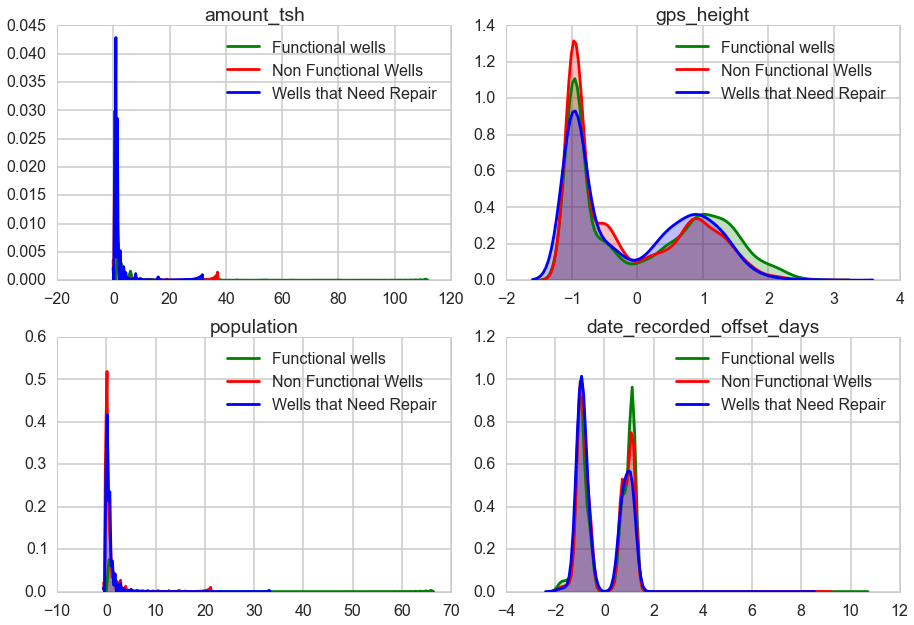

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2)
#plt.rc('xtick', labelsize=10) 
#plt.rc('ytick', labelsize=10) 
for i, feature in enumerate(STANDARDIZABLE):
    ax = axes[i/2, i%2]
    sns.kdeplot(df_new[df_new['status_group']=='functional'][feature], ax=ax, shade=True,color='green', label="Functional wells")
    sns.kdeplot(df_new[df_new['status_group']=='non functional'][feature], ax=ax, shade=True,color='red', label="Non Functional Wells")
    sns.kdeplot(df_new[df_new['status_group']=='functional needs repair'][feature], ax=ax, shade=True,color='blue', label="Wells that Need Repair")
    ax.set_title(feature)

fig.tight_layout()

In [20]:
CATEGORICAL = [u'funder', u'installer', u'basin', u'subvillage', u'region',
               u'public_meeting', u'scheme_management', u'permit',
               u'extraction_type', u'extraction_type_class',
               u'management', u'management_group', u'payment_type', u'water_quality',
               u'quantity', u'source', u'source_class', u'waterpoint_type', u'date_recorded_month']
for variable in CATEGORICAL:
    df_new[variable] = df_new[variable].astype('category')  

In [19]:
len(CATEGORICAL)

19

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


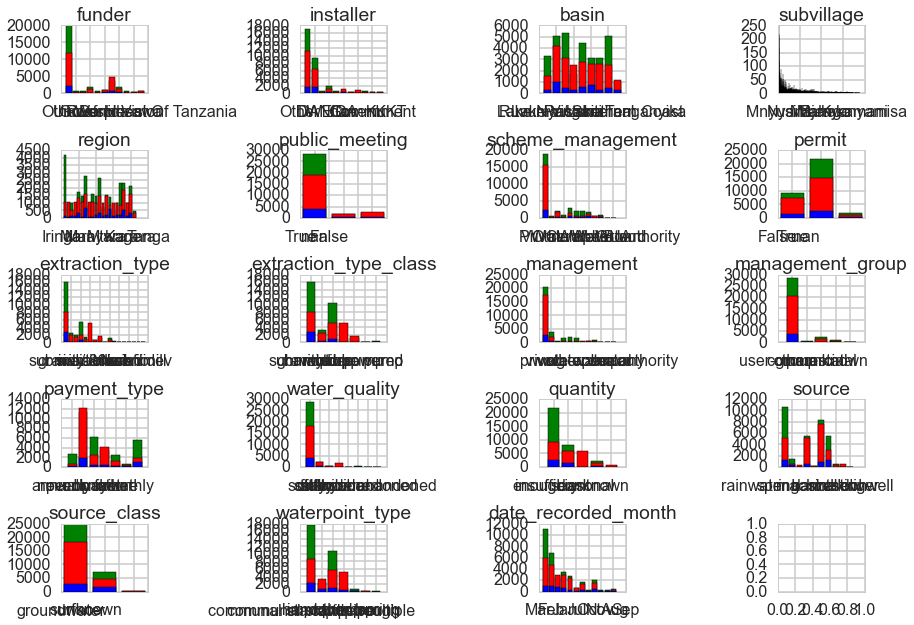

In [20]:
fig1, axes1 = plt.subplots(5,4)
#fig1.set_size_inches(15, 10.5)
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
for j, variable in enumerate(CATEGORICAL):
    ax1 = axes1[j/4,j%4]
    functional = df_new[df_new['status_group']=='functional'][variable].tolist()
    non_functional = df_new[df_new['status_group']=='non functional'][variable].tolist()
    needs_repair = df_new[df_new['status_group']=='functional needs repair'][variable].tolist()
    categories = pd.Series(df_new[variable].values.ravel()).unique()
    value_freq_funct = []
    value_freq_nonf = []
    value_freq_repair = []
    categories_num = range(1,len(categories)+1)
    for value in categories:
        value_freq_funct.append(functional.count(value))
        value_freq_nonf.append(non_functional.count(value))
        value_freq_repair.append(needs_repair.count(value))
    ax1.bar(categories_num,value_freq_funct,align='center',color='g')
    ax1.bar(categories_num,value_freq_nonf,align='center',color='r')
    ax1.bar(categories_num,value_freq_repair,align='center',color='b')
    ax1.set_xticklabels(categories)
    ax1.legend()
    ax1.set_title(variable)
    
fig1.tight_layout()
    
    
    
#     functional = df_new[df_new['status_group']=='functional']['funder'].tolist()
#     non_functional = df_new[df_new['status_group']=='non functional']['funder'].tolist()
#     needs_repair = df_new[df_new['status_group']=='functional needs repair']['funder'].tolist()
#     #labels = ["Positive Response", "Negative Response"]
#     ax1[j/3,j%3].hist([pos_resp,neg_resp], label=["Positive Response","Negative Response"], stacked=True)
#     ax1j.legend()
#     ax1j.set_title(indicator)

Let's take a closer look at some of them. In particular, ___ seem to show very interesting distributions.

In [21]:
#TODO

([<matplotlib.axis.XTick at 0x18537c2d0>,
  ...],
 <a list of 19288 Text xticklabel objects>)

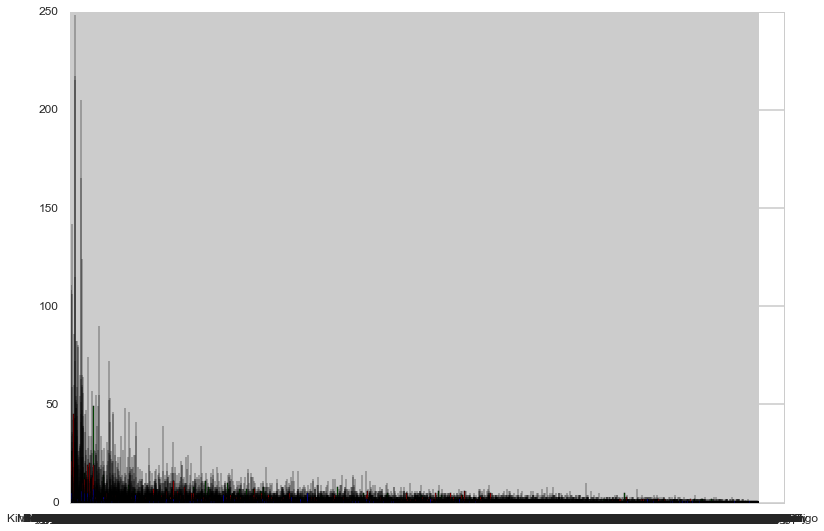

In [21]:
##To run
#for subvillages
functional = df_new[df_new['status_group']=='functional']['subvillage'].tolist()
non_functional = df_new[df_new['status_group']=='non functional']['subvillage'].tolist()
needs_repair = df_new[df_new['status_group']=='functional needs repair']['subvillage'].tolist()

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

categories = pd.Series(df_new.subvillage.values.ravel()).unique()
value_freq_funct = []
value_freq_nonf = []
value_freq_repair = []
categories_num = range(1,len(categories)+1)
for value in categories:
    value_freq_funct.append(functional.count(value))
    value_freq_nonf.append(non_functional.count(value))
    value_freq_repair.append(needs_repair.count(value))
fig.set_size_inches(8, 5)
plt.bar(categories_num,value_freq_funct,align='center',color='g')
plt.bar(categories_num,value_freq_nonf,align='center',color='r')
plt.bar(categories_num,value_freq_repair,align='center',color='b')
plt.xticks(categories_num, categories)

([<matplotlib.axis.XTick at 0x10cb080d0>,
 <a list of 11 Text xticklabel objects>)

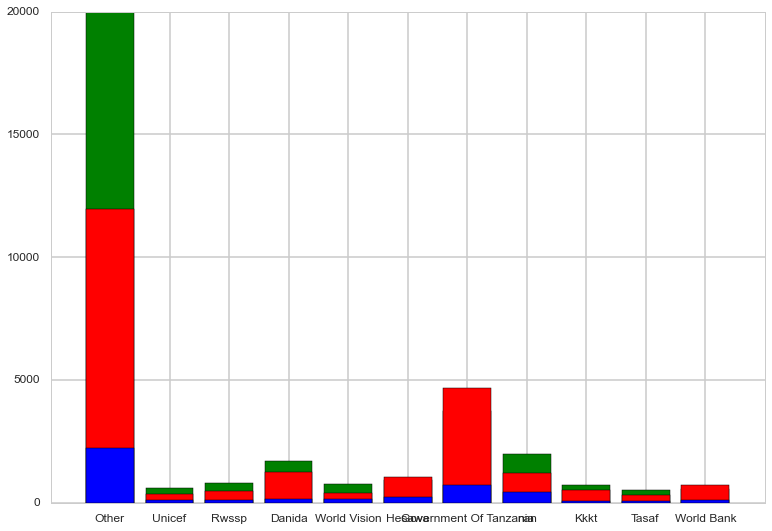

In [23]:
#for funders
functional = df_new[df_new['status_group']=='functional']['funder'].tolist()
non_functional = df_new[df_new['status_group']=='non functional']['funder'].tolist()
needs_repair = df_new[df_new['status_group']=='functional needs repair']['funder'].tolist()

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

categories = pd.Series(df_new.funder.values.ravel()).unique()
value_freq_funct = []
value_freq_nonf = []
value_freq_repair = []
categories_num = range(1,len(categories)+1)
for value in categories:
    value_freq_funct.append(functional.count(value))
    value_freq_nonf.append(non_functional.count(value))
    value_freq_repair.append(needs_repair.count(value))
fig.set_size_inches(8, 5)
plt.bar(categories_num,value_freq_funct,align='center',color='g')
plt.bar(categories_num,value_freq_nonf,align='center',color='r')
plt.bar(categories_num,value_freq_repair,align='center',color='b')
plt.xticks(categories_num, categories)

In [20]:
pd.Series(df.funder.values.ravel()).unique()

array(['Other', 'Unicef', 'Rwssp', 'Danida', 'World Vision', 'Hesawa',
       'Government Of Tanzania', nan, 'Kkkt', 'Tasaf', 'World Bank'], dtype=object)

# Models

First we write two functions: cv_optimize() use GridSearchCV to choose the best parameters for the model, and do_classify() to print out the model fit on the training and test sets.

In [23]:
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    gs.fit(X, y)
    print "BEST:", gs.best_params_
    return gs.best_estimator_

Here, we use the score() function in sklearn.linear_model.LogisticRegression. Other model evaluation/comparison measures we could consider are the balanced F-score (sklearn.metrics.f1_score()), the Kappa Statistic, Confusion Matrix, Hamming Loss, and Zero One loss. More options can be found here: http://scikit-learn.org/stable/modules/model_evaluation.html. (#TODO if more time)

In [24]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

There is a problem with using and reusing the test set to estimate the accuracy of a model. Specifically, we run into problems of overfitting since we use the results of on test set to adapt the model over multiple iteration, so that when we fit to the test set the nth time, the model is no longer completely independent of the test set that helped refine it in the previous example. Based on the findings of a recent paper that came out in _Science_, "The reusable holdout: Preserving validity in adaptive data analysis," we run a Thresholdout, where we add noise to the holdout set, or test set, every time we use it. Based on the relative accuracy measurements on the test and training set, we take either the training set's accuracy measurement of the test set's accuracy measurement plus random noise. We have a maximum number of times we can iterate based on the variance we allow in our measurements and the size of the holdout set. More information can be found here: http://arxiv.org/pdf/1506.02629v1.pdf and https://www.sciencemag.org/content/349/6248/636.short.

We added this functionality to do_classify in the function do_classify2().

In [27]:
#TODO if time

## Regression

Because we have a categorical outcome variable with more than one outcome, we conduct a multinomial logistic regression with LASSO (specifically, L2) regularization.

Sidenote: At this point, we realized that we were creating enough indicators to create several tens of thousands predictors, so we switched over to AWS. 

In [26]:
df_indicators = pd.get_dummies(df_new, columns=CATEGORICAL)
df_indicators.head()

,id,amount_tsh,gps_height,longitude,latitude,population,construction_year,date_recorded_offset_days,status_group,funder_Danida,...,date_recorded_month_Dec,date_recorded_month_Feb,date_recorded_month_Jan,date_recorded_month_Jul,date_recorded_month_Jun,date_recorded_month_Mar,date_recorded_month_May,date_recorded_month_Nov,date_recorded_month_Oct,date_recorded_month_Sep
0,69572,1.856690,1.045793,34.938093,-9.856322,-0.157363,y1999,1.143525,functional,0,...,0,0,0,0,0,1,0,0,0,0
1,8776,-0.103767,1.058817,34.698766,-2.147466,0.222265,y2010,-1.017447,functional,0,...,0,0,0,0,0,1,0,0,0,0
2,34310,-0.095599,0.027041,37.460664,-3.821329,0.155663,y2009,-0.990547,functional,0,...,0,1,0,0,0,0,0,0,0,0
3,67743,-0.103767,-0.585078,38.486161,-11.155298,-0.270586,Other,-0.906858,non functional,0,...,0,0,1,0,0,0,0,0,0,0
4,19728,-0.103767,-0.965663,31.130847,-1.825359,-0.399349,y0,0.781868,functional,0,...,0,0,0,1,0,0,0,0,0,0


In [25]:
df_new.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,date_recorded_offset_days,date_recorded_month,status_group
0,69572,1.856690,Other,1.045793,Other,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1.143525,Mar,functional
1,8776,-0.103767,Other,1.058817,Other,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,-1.017447,Mar,functional
2,34310,-0.095599,Other,0.027041,Other,37.460664,-3.821329,Pangani,Majengo,Manyara,...,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,-0.990547,Feb,functional
3,67743,-0.103767,Unicef,-0.585078,Other,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,-0.906858,Jan,non functional
4,19728,-0.103767,Other,-0.965663,Other,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,0.781868,Jul,functional


In [ ]:
##To run
feat_cols=list(df_indicators.columns)+STANDARDIZABLE
feat_cols.remove(u'status_group')
clfmlr, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l2",solver='newton-cg', multi_class='multinomial'), 
            {"C": [0.001, 0.1, 10.0, 100.0]}, df_indicators,feat_cols, u'status_group',1, mask=mask)

Based on the visualizations up above, with 1. the wells shown in their respective geographic locations and 2. the proportion of functional/non functional/functional-needs-repair different across regions and subvillages, we sense that there may be some sort of clustering of wells by subvillage and region. Thus, we first create a multilevel model with two levels, one for the individual wells and the second for the subvillages.

versions of optimizing:
- OLS (least bias)
- feature selection manually?
- regularization
    - ridge (posterior mean given a normal prior on the coefficients)
    - lasso (parameter shrinkage and selection; MAP given Laplace prior)

-use thresholdout to cross validation

## SVM

Bearing in mind that we have a large sample size, we begin by implementing a linear SVM, explicitly passing in the standard SVM hinge loss. We choose to begin here as the kernalized SVM training time that we will attempt later scales with the sample size, and we want to quickly classify on all features as a baseline. 

We will later move to classify using feature-selection, as well as possibly balancing. Finally, we will implement a kernalized SVM. 

In [22]:
from sklearn.svm import LinearSVC

In [35]:
print "# of categorical features:", len(CATEGORICAL)
print CATEGORICAL

# of categorical features: 19
[u'funder', u'installer', u'basin', u'subvillage', u'region', u'public_meeting', u'scheme_management', u'permit', u'extraction_type', u'extraction_type_class', u'management', u'management_group', u'payment_type', u'water_quality', u'quantity', u'source', u'source_class', u'waterpoint_type', u'date_recorded_month']


Recall that we found 19 categorical features in this data set. While we could encode these variables as ordinal numbers, our classifying algorithms expect a continuous input. Therefore, we turn to one-of-K, or one-hot, encoding to transform each categorical feature with $m$ possible values into $m$ binary features, of which only one is active. 

In [53]:
# subset only the categorical values to transform
df_categorical = df_new.drop(STANDARDIZABLE + ['id', 'longitude', 'latitude', 'construction_year', 'status_group'], axis=1)
print df_categorical.columns.values
df_categorical.head()

['funder' 'installer' 'basin' 'subvillage' 'region' 'public_meeting'
 'scheme_management' 'permit' 'extraction_type' 'extraction_type_class'
 'management' 'management_group' 'payment_type' 'water_quality' 'quantity'
 'source' 'source_class' 'waterpoint_type' 'date_recorded_month']


,funder,installer,basin,subvillage,region,public_meeting,scheme_management,permit,extraction_type,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,date_recorded_month
0,Other,Other,Lake Nyasa,Mnyusi B,Iringa,True,VWC,False,gravity,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,Mar
1,Other,Other,Lake Victoria,Nyamara,Mara,NaN,Other,True,gravity,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,Mar
2,Other,Other,Pangani,Majengo,Manyara,True,VWC,True,gravity,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,Feb
3,Unicef,Other,Ruvuma / Southern Coast,Mahakamani,Mtwara,True,VWC,True,submersible,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,Jan
4,Other,Other,Lake Victoria,Kyanyamisa,Kagera,True,NaN,True,gravity,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,Jul


In [54]:
# encode categorical features with 1-of-K or one-hot encoding
enc = prepr.OneHotEncoder()
enc.fit(df_categorical)  
# OneHotEncoder(categorical_features=CATEGORICAL, dtype=<... 'float'>,
#        handle_unknown='error', n_values='auto', sparse=True)
# enc.transform([[0, 1, 3]]).toarray()

ValueError: invalid literal for long() with base 10: 'Mar'

In [50]:
df_categorical['construction_year']

0        y1999
1        y2010
2        y2009
3        Other
4           y0
5        y2009
6           y0
7           y0
8           y0
9           y0
10       y2011
11       Other
12          y0
13       y2009
14          y0
15       Other
16       y1978
17       y1978
18       y1999
19       Other
20       y2008
21          y0
22       y1978
23       y2011
24       y2009
25       Other
26       y2011
27          y0
28       y2000
29       y2002
         ...  
59370       y0
59371       y0
59372       y0
59373    Other
59374       y0
59375    y2005
59376    y1990
59377       y0
59378    y2008
59379       y0
59380    y1999
59381    Other
59382    y2008
59383    y2008
59384       y0
59385    y2011
59386    y2009
59387    y2000
59388    y1995
59389    y2009
59390    Other
59391    Other
59392       y0
59393       y0
59394    y2007
59395    y1999
59396    Other
59397       y0
59398       y0
59399    y2002
Name: construction_year, dtype: object

In [31]:
# list of features
lcols=list(df_new.columns)
lcols.remove(u'status_group')
print len(lcols)

27


In [32]:
clfsvm=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=df_new[lcols].values
Yresp=df_new['status_group'].values

Optimization

In [29]:
jtrain=np.arange(0, ytrain.shape[0])
# n_pos=len(jtrain[ytrain==1])
# n_neg=len(jtrain[ytrain==0])
# print n_pos, n_neg

NameError: name 'ytrain' is not defined

In [28]:
df_new.groupby(['status_group']).count()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,date_recorded_offset_days,date_recorded_month
status_group,,,,,,,,,,,,,,,,,,,,,
functional,32259,32259,30278,32259,30259,32259,32259,32259,32054,32259,...,32259,32259,32259,32259,32259,32259,32259,32259,32259,32259
functional needs repair,4317,4317,3880,4317,3877,4317,4317,4317,4316,4317,...,4317,4317,4317,4317,4317,4317,4317,4317,4317,4317
non functional,22824,22824,21607,22824,21609,22824,22824,22824,22659,22824,...,22824,22824,22824,22824,22824,22824,22824,22824,22824,22824
